## Cellpose 3D Template

This template was done in part to help with this [forum question](https://forum.image.sc/t/cellpose-3d-artifacts/105504)

To run you need an environment with cellpose 3.1.0 and the development version of tnia-python for some visualizations. 

```
pip install cellpose==3.1.0
pip install clij2-fft==0.
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python.git 

In [38]:
from skimage.io import imread
import os
import numpy as np
from tnia.plotting.projections import show_xy_zy_max
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from tnia.plotting.projections import show_xy_zy_max
from tnia.plotting.plt_helper import create_rgb, imshow_multi2d, create_linear_napari_color_map, get_color


In [ ]:
parent_path =r'D:\images\tnia-python-images\imagesc\2024_12_03_cellpose_3D'
im_ = imread(os.path.join(parent_path, r'hanmu_halfscale.tif'))
print(im_.shape)

deconvolve = False

(134, 1152, 1152, 4)


In [40]:
# crop the image
ind = np.s_[:im_.shape[0]//2,im_.shape[1]//4:3*im_.shape[1]//4,im_.shape[2]//4:3*im_.shape[2]//4, 0:2]
im = im_[ind]
print(im.shape)

(67, 576, 576, 2)


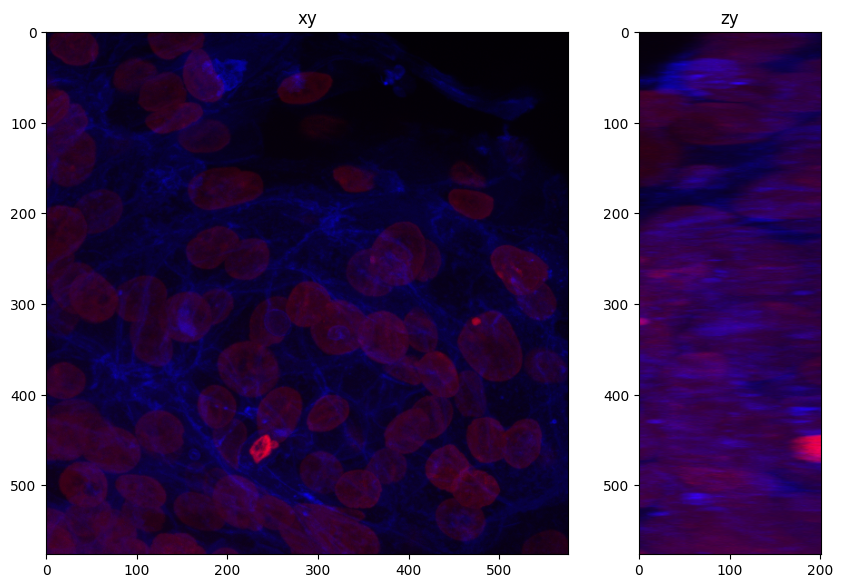

In [41]:
rgb = create_rgb(im)
fig = show_xy_zy_max(rgb,sz=3,figsize=(10,10))

In [42]:
import napari 
viewer = napari.Viewer()

for i in range(im.shape[-1]):
    color = get_color(i)
    new_colormap = create_linear_napari_color_map(str(i), color)
    viewer.add_image(im[...,i], name='im', colormap=new_colormap, blending='additive')
    #viewr.add_image(im, name='im')

In [43]:
deconvolve = False

if deconvolve:
    from clij2fft.richardson_lucy import richardson_lucy, richardson_lucy_nc
    from tnia.deconvolution.gaussian_psf import gaussian_3d
    from tnia.plotting.projections import show_xy_zy_max
    psf = gaussian_3d(128, 32, 1, 3)
    fig = show_xy_zy_max(psf)

    deconvolved = np.zeros_like(im)

    for i in range(im.shape[-1]):
        deconvolved[...,i] = richardson_lucy_nc(im[...,i], psf, 100, 0.002)

    im = deconvolved

In [44]:
if deconvolve:

    viewer = napari.Viewer()
    viewer.add_image(im[...,0], name='im0')
    viewer.add_image(deconvolved[...,0], name='deconvolved0')
    viewer.add_image(im[...,1], name='im1')
    viewer.add_image(deconvolved[...,1], name='deconvolved1')

In [46]:
from cellpose import models, io
import logging
logging.basicConfig(level=logging.DEBUG)
mod = models.Cellpose(gpu=True, model_type="cyto3")

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model C:\Users\bnort\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


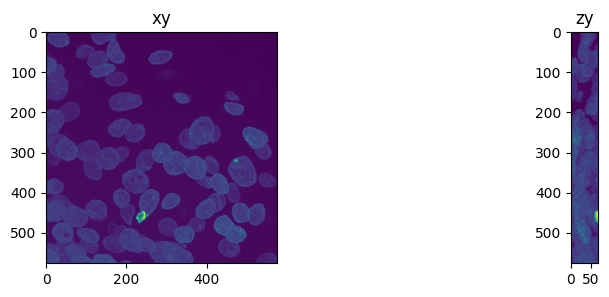

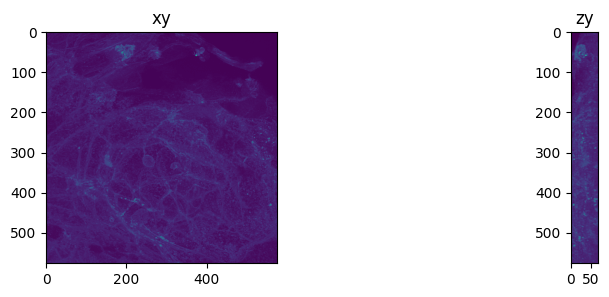

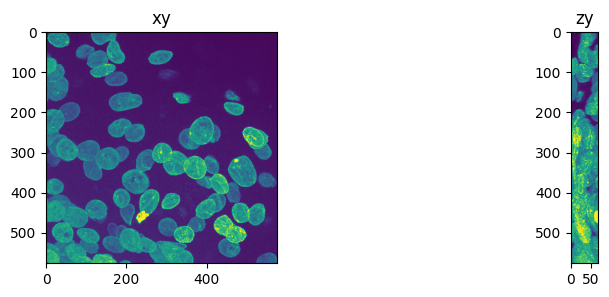

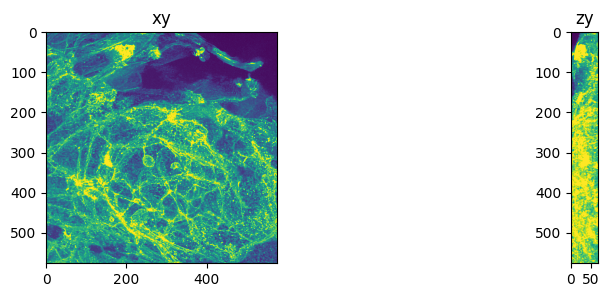

In [31]:
from tnia.deeplearning.dl_helper import quantile_normalization, get_label_paths

normalized = quantile_normalization(im, quantile_low=0.001, quantile_high=0.999)

fig = show_xy_zy_max(im[...,0])
fig = show_xy_zy_max(im[...,1])

fig = show_xy_zy_max(normalized[...,0])
fig = show_xy_zy_max(normalized[...,1])

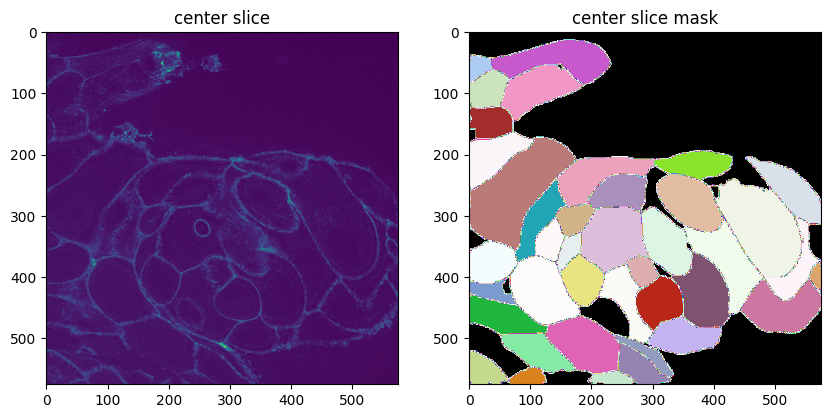

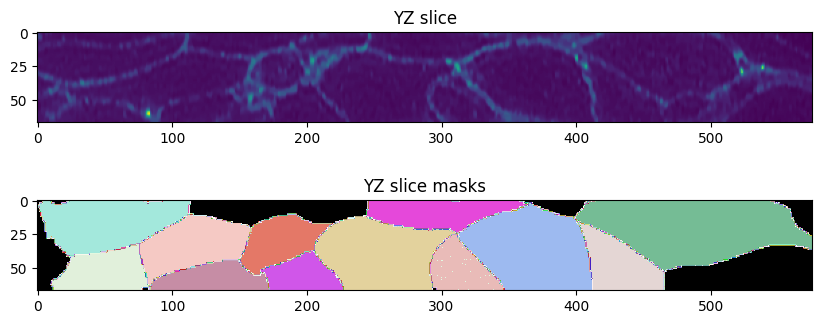

In [32]:
# get center slice 
xy_slice_num = 19
diameter = 90

center_slice = im[xy_slice_num,...]
YZ_slice = im[:,im.shape[1]//2,...]

center_slice_masks = mod.eval(center_slice, diameter=diameter)
YZ_slice_masks = mod.eval(YZ_slice, diameter=diameter)

fig = imshow_multi2d([center_slice[...,1], center_slice_masks[0]], ['center slice', 'center slice mask'], 1, 2, height=15, colormaps=[None, random_label_cmap()])

fig = imshow_multi2d([YZ_slice[...,1], YZ_slice_masks[0]], ['YZ slice', 'YZ slice masks'], 2, 1, colormaps=[None, random_label_cmap()])  

In [28]:
print(center_slice.shape)

(576, 576, 2)


In [29]:
viewer = napari.Viewer()

viewer.add_image(center_slice[...,1], name='center_slice')
viewer.add_labels(center_slice_masks[0], name='center_slice_masks')

<Labels layer 'center_slice_masks' at 0x1a620631c00>

In [35]:
mask3D = mod.eval(im, diameter=150, channels=[2,1], anisotropy=3,  do_3D=True, niter=200, channel_axis=3, dP_smooth=5)[0]

In [37]:
import napari

viewer = napari.Viewer()

viewer.add_image(im[...,0], name='ch0')
viewer.add_image(im[...,1], name='ch1')
#viewer.add_image(normalized, name='normalized')
viewer.add_labels(np.array(mask3D), name='mask3D')

<Labels layer 'mask3D' at 0x1a54a618280>